In [33]:
import numpy as np
import os
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path
from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

import rootutils
rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)

import src.utils.prepare_zhuang_abca

In [34]:
def plot_sections_from_adata(adata_dict, example_section, color_key=None, value_key=None, fig_width=10, fig_height=10, cmap=None):
    """
    Plots sections using AnnData objects.

    Parameters:
        adata_dict (dict): Dictionary of AnnData objects, keyed by sample (slice) names.
        example_section (list): List of sample names to plot.
        color_key (str): Key in `adata.obs` to use for coloring points (e.g., 'parcellation_division_color').
        value_key (str): Key in `adata.obs` to use for colormap values (e.g., a numeric column in `adata.obs`).
        fig_width (float): Width of the figure.
        fig_height (float): Height of the figure.
        cmap (str or Colormap): Colormap to use if `value_key` is provided.

    Returns:
        tuple: (fig, ax) Matplotlib figure and axes objects.
    """
    # Filter the adata_dict to include only the samples in example_section
    filtered_adata_dict = {sample: adata_dict[sample] for sample in example_section if sample in adata_dict}

    # Determine the number of subplots needed
    num_samples = len(filtered_adata_dict)
    if num_samples == 0:
        raise ValueError("No matching samples found in adata_dict for the provided example_section.")

    rows = int(np.ceil(num_samples / 2))  # Adjust rows for a 2-column layout
    fig, ax = plt.subplots(rows, 2, figsize=(fig_width, fig_height))
    ax = ax.flatten()  # Flatten the axes array for easier indexing

    # Iterate over the filtered samples and plot each section
    for i, (sample_name, adata) in enumerate(filtered_adata_dict.items()):
        # Extract spatial coordinates
        if 'spatial' not in adata.obsm:
            print(f"Warning: 'spatial' coordinates not found in {sample_name}. Skipping.")
            continue

        spatial_coords = adata.obsm['spatial']

        # Plot the data
        if value_key is not None and value_key in adata.obs:
            scatter = ax[i].scatter(
                spatial_coords[:, 0], spatial_coords[:, 1],
                s=0.5, c=adata.obs[value_key], marker='.', cmap=cmap
            )
        elif color_key is not None and color_key in adata.obs:
            scatter = ax[i].scatter(
                spatial_coords[:, 0], spatial_coords[:, 1],
                s=0.5, c=adata.obs[color_key], marker='.'
            )
        else:
            print(f"Warning: Neither '{value_key}' nor '{color_key}' found in {sample_name}. Skipping.")
            continue

        # Set plot properties
        ax[i].set_ylim(11, 0)
        ax[i].set_xlim(0, 11)
        ax[i].axis('equal')
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_title(sample_name)

    # Hide any unused subplots
    for j in range(i + 1, len(ax)):
        ax[j].axis('off')

    return fig, ax

In [35]:
adata1 = sc.read_h5ad("../data/domain/raw/Zhuang-ABCA-4.001.h5ad")
adata2 = sc.read_h5ad("../data/domain/raw/Zhuang-ABCA-4.002.h5ad")
adata3 = sc.read_h5ad("../data/domain/raw/Zhuang-ABCA-4.003.h5ad")
all_adata = {"Zhuang-ABCA-4.001": adata1, "Zhuang-ABCA-4.002": adata2, "Zhuang-ABCA-4.003": adata3}
all_adata["Zhuang-ABCA-4.001"]

AnnData object with n_obs × n_vars = 32311 × 1122
    obs: 'brain_section_label', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'abc_sample_id', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_index', 'parcellation_organ', 'parcellation_category', 'parcellation_division', 'parcellation_structure', 'parcellation_substructure', 'parcellation_organ_color', 'parcellation_category_color', 'parcellation_division_color', 'parcellation_structure_color', 'parcellation_substructure_color'
    obsm: 'spatial'

In [36]:
example_section = ["Zhuang-ABCA-4.001", "Zhuang-ABCA-4.002", "Zhuang-ABCA-4.003"]

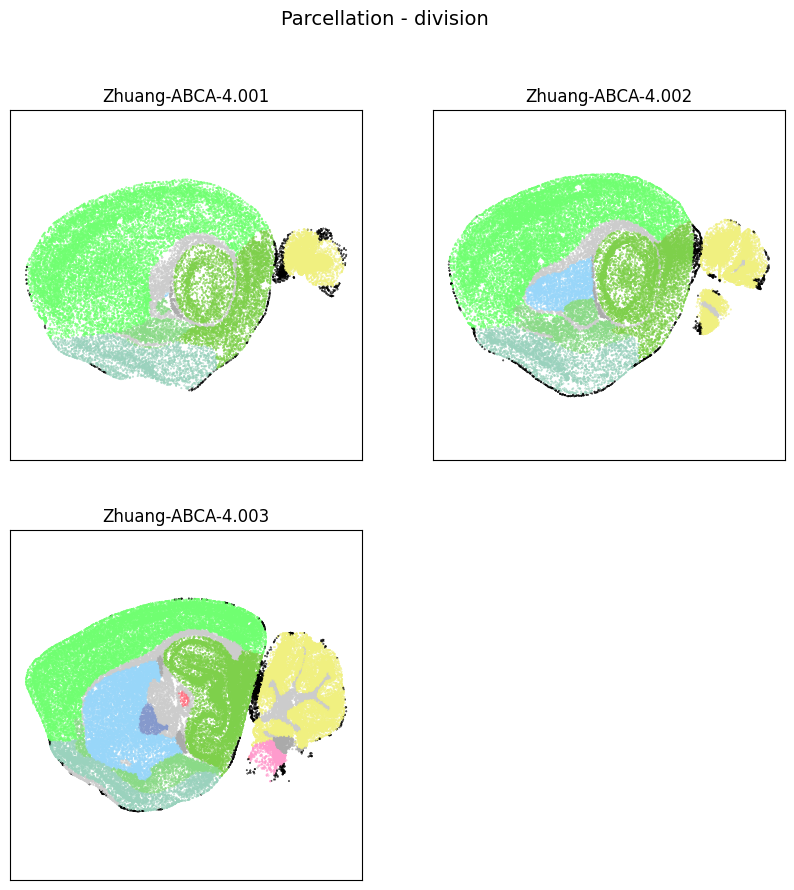

In [ ]:
fig, ax = plot_sections_from_adata(all_adata, example_section, 'parcellation_division_color')
res = fig.suptitle('Parcellation - division', fontsize=14)
plt.show()

In [58]:
adata3.obs_keys()

['brain_section_label',
 'feature_matrix_label',
 'donor_label',
 'donor_genotype',
 'donor_sex',
 'cluster_alias',
 'x',
 'y',
 'z',
 'subclass_confidence_score',
 'cluster_confidence_score',
 'high_quality_transfer',
 'abc_sample_id',
 'neurotransmitter',
 'class',
 'subclass',
 'supertype',
 'cluster',
 'neurotransmitter_color',
 'class_color',
 'subclass_color',
 'supertype_color',
 'cluster_color',
 'x_ccf',
 'y_ccf',
 'z_ccf',
 'parcellation_index',
 'parcellation_organ',
 'parcellation_category',
 'parcellation_division',
 'parcellation_structure',
 'parcellation_substructure',
 'parcellation_organ_color',
 'parcellation_category_color',
 'parcellation_division_color',
 'parcellation_structure_color',
 'parcellation_substructure_color']

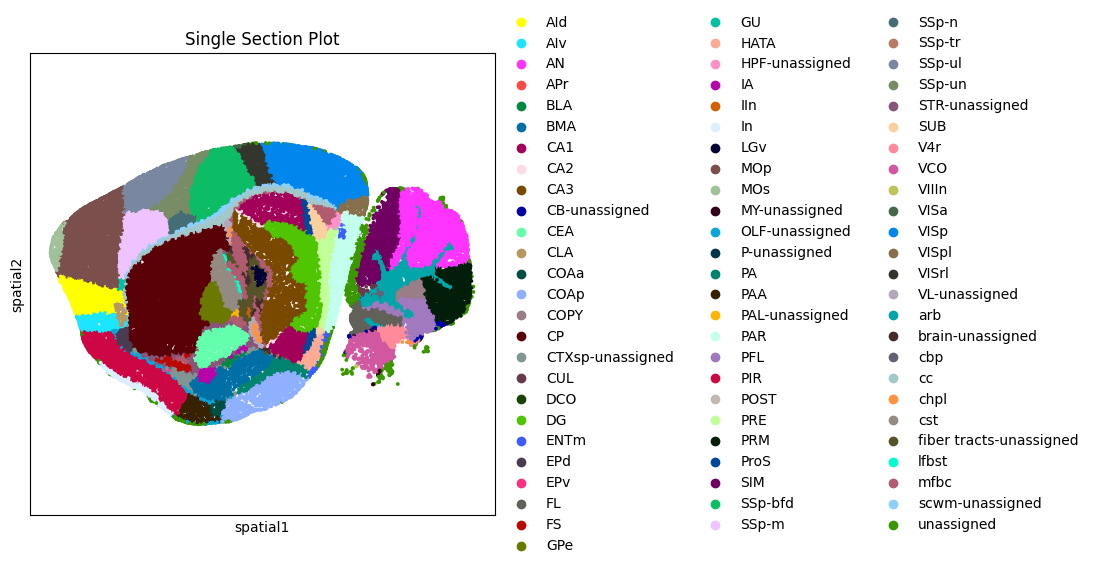

In [60]:
adata = adata3
color_key = "parcellation_structure"  # Key in adata.obs for coloring

fig, ax = plt.subplots(figsize=(6, 6))
sc.pl.embedding(
    adata,
    basis="spatial",  # Use the 'spatial' basis
    color=color_key,  # Color by the desired key
    size=30,          # Adjust point size
    ax=ax,            # Use the custom subplot
    show=False        # Prevent immediate display
)

ax.set_ylim(11, 0)  # Flip the y-axis
ax.set_xlim(0, 11)  # Set x-axis limits
ax.axis("equal")    # Ensure equal aspect ratio
ax.set_xticks([])   # Remove x-axis ticks
ax.set_yticks([])   # Remove y-axis ticks
ax.set_title("Single Section Plot")  # Add a title

# Show the plot
plt.show()

In [26]:
adata1

AnnData object with n_obs × n_vars = 32311 × 1122
    obs: 'brain_section_label', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'cluster_alias', 'x', 'y', 'z', 'subclass_confidence_score', 'cluster_confidence_score', 'high_quality_transfer', 'abc_sample_id', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_index', 'parcellation_organ', 'parcellation_category', 'parcellation_division', 'parcellation_structure', 'parcellation_substructure', 'parcellation_organ_color', 'parcellation_category_color', 'parcellation_division_color', 'parcellation_structure_color', 'parcellation_substructure_color'
    obsm: 'spatial'

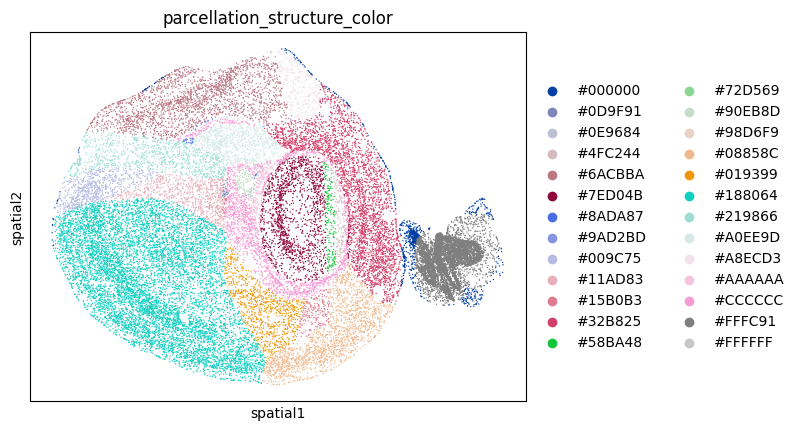

In [43]:
sc.pl.embedding(adata1, basis='spatial', color="parcellation_structure_color")